Lets import all the pkgs needed

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import datetime

import matplotlib.pyplot as plt

We start by reading in the data

In [2]:
data = pd.read_csv("final_dataset_stocks.csv")
data.head()

,Unnamed: 0,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,...,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Volume,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
0,0,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16068.824,NaN
1,1,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1257.60,--,0.00,0.00,0.00,.,16068.824,NaN
2,2,2012-01-03,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.97998,...,2648.719971,1.636850e+09,1277.06,--,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,3,2012-01-04,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.22998,...,2648.360107,1.670530e+09,1277.30,--,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,4,2012-01-05,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.22998,...,2669.860107,1.836410e+09,1281.06,--,1277.30,1283.05,1265.26,2.12,16068.824,2.02


We will drop the index column that came with the dataset 

In [3]:
data.drop(columns=['Unnamed: 0'], inplace=True)

we will drop the rows that includes na

In [4]:
#The rows with NaN are days when market was closed. I will be deleting those rows.
data.dropna(inplace=True)

In [5]:
data.head()

,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Volume,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
2,2012-01-03,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1.636850e+09,1277.06,--,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,2012-01-04,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1.670530e+09,1277.30,--,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,2012-01-05,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1.836410e+09,1281.06,--,1277.30,1283.05,1265.26,2.12,16068.824,2.02
5,2012-01-06,122.9651,123.0251,121.5780,121.7314,4897100.0,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1.683090e+09,1277.81,--,1280.93,1281.84,1273.34,2.09,16068.824,1.98
8,2012-01-09,121.5047,121.5513,120.2176,121.0979,5201200.0,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1.768080e+09,1280.70,--,1277.83,1281.99,1274.55,2.11,16068.824,1.98


Even though we have removed null values, there still might be wrong non-numeric values here. Let's look at those dtypes.

In [6]:
data.select_dtypes(include=[object])

,date,SP_Volume,interest_rate,yield_rate
2,2012-01-03,--,2.01,1.97
3,2012-01-04,--,2.08,2.00
4,2012-01-05,--,2.12,2.02
5,2012-01-06,--,2.09,1.98
8,2012-01-09,--,2.11,1.98
...,...,...,...,...
3601,2021-11-10,--,2.7,1.56
3602,2021-11-11,--,.,.
3603,2021-11-12,--,2.73,1.58
3606,2021-11-15,--,2.76,1.63


In [7]:
data['SP_Volume'].value_counts()

--    2486
Name: SP_Volume, dtype: int64

Since all values are null, we will drop this column.

In [8]:
data.drop(columns=['SP_Volume'], inplace=True)

Next, we can notice some values in columns 'interest_rate' and 'yeild_rate' are "."

Let us replace it by the next numeric value in the series.

In [9]:
#Replacing values in yield_curves
for i in range(len(data)):
  if data.iloc[i,-1] == '.':
    data.iloc[i,-1] = data.iloc[i + 1,-1] 

In [10]:
data.columns.get_loc("interest_rate")

16

In [11]:
#Replacing values in interest rate
for i in range(len(data)):
  if data.iloc[i,16] == '.':
    data.iloc[i,16] = data.iloc[i + 1,16] 

In [12]:
#Converting the above columns into float
data['yield_rate'] = data['yield_rate'].astype('float')
data['interest_rate'] = data['interest_rate'].astype('float')
df=data

In [13]:
#Finally lets convert date string to datetime format
#for i in range(len(data)):
  #data.iloc[i,0] = datetime.datetime.strptime(data.iloc[i,0], '%Y-%m-%d')

data['date'] = pd.to_numeric(pd.to_datetime(data['date']))

In [14]:
data.head()

,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
2,1325548800000000000,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1.636850e+09,1277.06,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,1325635200000000000,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1.670530e+09,1277.30,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,1325721600000000000,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1.836410e+09,1281.06,1277.30,1283.05,1265.26,2.12,16068.824,2.02
5,1325808000000000000,122.9651,123.0251,121.5780,121.7314,4897100.0,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1.683090e+09,1277.81,1280.93,1281.84,1273.34,2.09,16068.824,1.98
8,1326067200000000000,121.5047,121.5513,120.2176,121.0979,5201200.0,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1.768080e+09,1280.70,1277.83,1281.99,1274.55,2.11,16068.824,1.98


Now, let us split the data into X and y. Since we are trying to predict the price of the Closing price of the IBM stock, we will make our split accordingly.

In [15]:
X = data.drop(columns =['IBM_close'])
y = data.IBM_close.values

Using sklearn, we will create a train_test_split.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

We will use the train data to build a linear regression


In [17]:
#LINEAR REGRESSION MODEL
model = LinearRegression().fit(X_train, y_train)

#evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print((np.mean(scores), np.std(scores)))

#predicted y values
y_pred = model.predict(X_test)
print(y_pred)

(6.073334662935707, 0.37511232198875466)
[120.62078966 112.45546312 131.63881976 131.50574025 117.95023467
 118.55361901 117.73053409 115.71729624 115.33917919 111.87791342
 112.74687667 111.88557633 118.17654385 115.63466771 128.15038089
 114.00272869 118.70462872 117.15992299 127.94798929 127.0403712
 118.31802769 115.86970303 109.7260114  126.31174576 130.93897422
 115.13592669 128.57326589 114.11888264 118.4640454  115.01754263
 117.28841688 119.92733529 129.12662628 108.56728828 117.34713327
 130.05033074 109.24957378 130.96661969 119.76404716 118.18865965
 128.33665386 129.61380918 112.54610644 116.67185857 114.76825196
 108.27722133 118.46419363 112.87777556 119.49758567 129.40530732
 127.40338789 123.75646196 129.1664005  117.19194966 118.69381369
 128.04060588 118.59265478 130.39749624 112.51458515 118.38678432
 129.04387596 104.71199326 124.96050949 126.84215138 127.86563158
 112.17327198 126.99041136 112.46658198 130.74368572 116.66572366
 117.59092582 108.84469018 105.35750

In [18]:
#RIDGE REGRESSION
#can also test around with the alpha value, currently set to the default 1
ridgemodel = Ridge(alpha=1.0)

#k=5 or 10 is very common that generally result in a model skill estimate with low bias a modest variance
#can change this later
#repeat this process 3 times to get an average 
#evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(ridgemodel, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print((np.mean(scores), np.std(scores)))

#making predictions on test data
#first fit the data
ridgemodel.fit(X_train,y_train)
y_pred2 = ridgemodel.predict(X_test)
print(y_pred2)

(0.3062391758253947, 0.014967010553487882)
[117.6476208  113.73450561 129.20584827 133.44067653 128.30062003
 117.77219854 134.98667824 113.05531948 108.05042145 114.37830123
 114.52993304 102.39897016 119.48863066 115.63014613 137.5571148
 119.4166007  116.03272334 115.58018092 137.25129776 109.89266957
 113.71664038 120.36401741  90.20110066 113.61851437 134.49359537
 115.39997346 128.62972631 121.075848   114.36107291 120.68948324
 116.77964989 101.0991037  132.50728425 110.00543262  98.51231367
 135.72335424  94.00356836 130.37887998 118.04434959 119.34091384
 127.46182306 129.54635128 114.35058981 114.54183297 105.81873835
 102.33321332 113.11541662  89.54356162 108.62632634 130.56619089
 130.17687589 131.4778233  130.74468864 122.05697532 119.23244577
 115.51457729 125.72796788 129.28442217 111.26596568 123.48765327
 127.29286651 105.52047573 130.68318236 122.89028018 134.13583047
 114.58369466 124.20681839 115.23718075 126.91197667 116.02698631
 109.65116736 113.4190887   96.522

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.17401e-37): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [19]:
#LASSO REGRESSION
#can also test around with the alpha value, currently set to the default 1
lassomodel = Lasso(alpha=1.0)

#evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(lassomodel, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print((np.mean(scores), np.std(scores)))

#making predictions on test data
#first fit the data
lassomodel.fit(X_train,y_train)
y_pred3 = lassomodel.predict(X_test)
print(y_pred3)

(0.44897213255576623, 0.026307284179480955)
[117.7385551  114.51748742 129.50817932 133.47270058 127.94924371
 117.647467   134.9500158  113.26122447 107.81825859 114.40170439
 114.0320967  102.7809978  119.33673446 116.20410733 137.77760976
 119.28776761 115.81360053 115.45620779 137.34933753 110.58887305
 113.83029803 120.23217305  90.21273413 113.84176614 134.29531853
 115.36867593 129.05947787 121.15403894 114.17156442 120.94594142
 116.29886115 101.42689232 132.62962778 110.07966128  99.05464482
 136.0525724   94.39436651 129.75650229 118.32755196 119.43141426
 127.489438   129.67055398 114.55603488 114.74807896 105.41880422
 100.75134474 113.19942922  89.6012088  108.82412589 130.7752611
 129.90595568 131.17344457 130.96280602 122.81016822 119.13657818
 115.46986792 125.03154845 129.32010965 111.45723916 123.71073641
 127.61534846 106.20768667 131.00216433 123.2123995  133.44887984
 114.68808832 124.34844472 114.98220781 127.00103802 115.90778182
 110.00344695 112.89420984  96.57

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2046.4430244271946, tolerance: 23.086443122193337
  model = cd_fast.enet_coordinate_descent(


In [20]:
#ELASTIC NET REGRESSION
elasticmodel = ElasticNet(alpha=1.0, l1_ratio=0.5)

#evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(elasticmodel, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print((np.mean(scores), np.std(scores)))

#making predictions on test data
#first fit the data
elasticmodel.fit(X_train,y_train)
y_pred4 = elasticmodel.predict(X_test)
print(y_pred4)

(0.4499573318722931, 0.02750736480563635)
[117.70324873 114.61428402 129.51642903 133.49023321 127.95832814
 117.64458128 135.05327068 113.25679562 107.79502219 114.41598267
 114.06677056 102.73742981 119.36081834 116.20752645 137.82489573
 119.34762734 115.85698344 115.46852082 137.40218142 110.54477708
 113.82815449 120.27483364  90.06657143 113.7920145  134.31814183
 115.37974338 129.06993319 121.16804825 114.13686526 120.98479188
 116.27302126 101.35897302 132.67545884 110.07867548  99.01604794
 136.06099772  94.36988748 129.7310846  118.33486083 119.47069574
 127.49774746 129.68138968 114.56327472 114.7816632  105.39252267
 100.64830447 113.18959272  89.50724306 108.79994028 130.80662664
 129.90489227 131.15217085 130.99236314 122.80340633 119.13516298
 115.45202428 124.96070313 129.30960846 111.47604828 123.76093396
 127.62379526 106.19891793 130.98891378 123.20029626 133.44366447
 114.67962484 124.34584275 114.98270472 126.97966899 115.90646753
 109.98245622 112.93333125  96.542

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1383.54700652861, tolerance: 23.086443122193337
  model = cd_fast.enet_coordinate_descent(


In [21]:
#this converts the numeric date back to datetime (just to make the graph prettier)
#this is for actual date
for i in range(len(data)):
  your_timestamp = data.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  data.iloc[i,0] = date.date()
data.date = pd.to_datetime(data['date'])

#this is for the X_test
for i in range(len(X_test)):
  your_timestamp = X_test.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  X_test.iloc[i,0] = date.date()
X_test.date = pd.to_datetime(X_test['date'])
display(X_test)

/Users/seangao/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/seangao/.local/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,date,IBM_open,IBM_high,IBM_low,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
1297,2015-07-20,118.0665,119.5106,116.3998,13747503.0,5219.200195,5229.000000,5196.299805,5208.120117,5208.120117,1.774570e+09,2119.21,2127.55,2128.49,2115.40,1.82,18306.960,2.35
3207,2020-10-11,114.7761,114.9374,113.3153,4630916.0,11732.330078,11965.540039,11704.129883,11876.259766,11876.259766,3.862990e+09,3534.22,3500.02,3549.85,3499.61,1.70,21477.597,0.74
51,2012-02-20,129.6959,130.0373,128.8457,3293600.0,2957.300049,2965.050049,2934.070068,2948.570068,2948.570068,1.821540e+09,1362.21,1361.22,1367.76,1358.11,2.27,16068.824,2.05
582,2013-08-04,133.5268,134.0194,132.9726,2490900.0,3682.669922,3694.189941,3681.340088,3692.949951,3692.949951,1.471860e+09,1707.14,1708.01,1709.24,1703.55,2.25,16911.068,2.67
1830,2017-01-03,127.3293,128.9231,127.0181,3381232.0,5440.910156,5482.350098,5440.240234,5477.000000,5477.000000,1.883360e+09,2270.75,2261.60,2272.82,2261.60,1.99,19153.912,2.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2770,2019-08-01,125.7807,129.0892,122.8774,8101720.0,8056.419922,8068.799805,7953.669922,8004.069824,8004.069824,2.252550e+09,2932.05,2943.90,2945.50,2914.11,1.66,21505.012,1.86
715,2013-12-15,119.7442,123.2905,119.4055,7517000.0,4019.370117,4043.000000,4019.139893,4029.520020,4029.520020,1.943830e+09,1786.54,1777.48,1792.22,1777.48,2.18,17133.114,2.89
156,2012-06-04,126.3370,127.6346,126.0950,3556500.0,2749.350098,2781.969971,2749.340088,2778.110107,2778.110107,1.625600e+09,1285.50,1277.82,1287.62,1274.16,2.13,16207.130,1.57
2159,2017-11-28,120.4793,121.1101,119.9747,5095567.0,6907.279785,6908.330078,6793.950195,6824.390137,6824.390137,2.452860e+09,2626.07,2627.82,2634.89,2620.32,1.84,19882.965,2.37


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


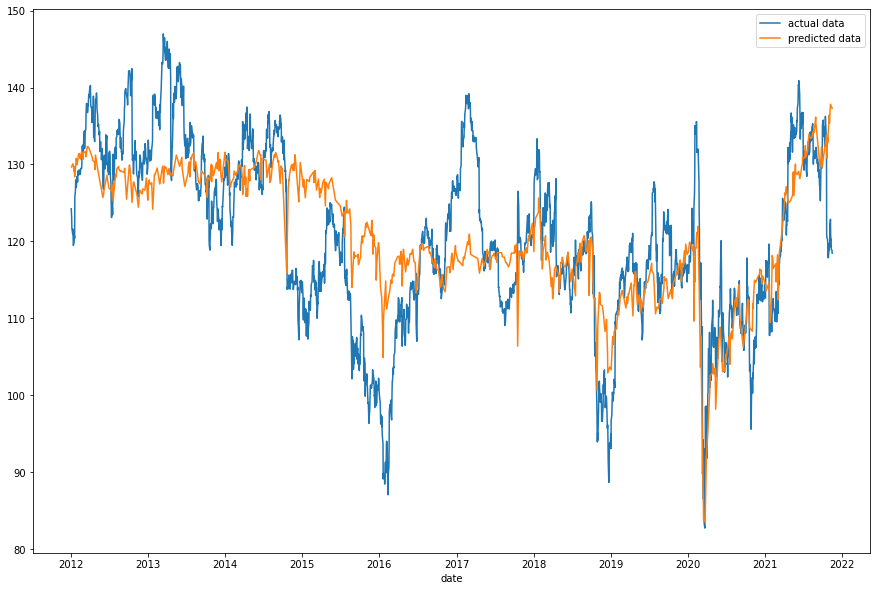

In [22]:
#PLOT THE LINEAR REGRESSION MODEL WITH PREDICTED VALUES
# this increases the figure size for added viewability
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

#plots the linear regression model
plt.plot(data['date'],y, label ="actual data")
ax = sns.lineplot(X_test['date'],y_pred, label ="predicted data")
plt.show()

The Model above we trained multiple different linear regression models, we below we will train the random forest model below.

We start by splitting the data using Train_test_split

In [23]:
#construct X,y
# X = df.drop(columns =['IBM_close'])
# y = df.IBM_close.values


#split the data into train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# #Feature scaling for random forest 
# from sklearn.preprocessing import StandardScaler
XX_test = X_test
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# display(X_train)
# X_test = sc.transform(X_test)

we will trian the Random Forrest here 

In [24]:
#import a few things here 
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

In [25]:
# Create RF
# Here we use the default MSE for our criterion
rf = RandomForestRegressor(n_estimators=10000, max_depth=3, n_jobs=-1, random_state=1,max_features=6,min_samples_leaf=2)

# Now we'll train/test
rf.fit(X_train,y_train)
ypr = rf.predict(X_test)


cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
n_scores = cross_val_score(model, X, y,scoring='neg_mean_squared_error' ,cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Negative MSE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))






Negative MSE: -63.088 (4.265)


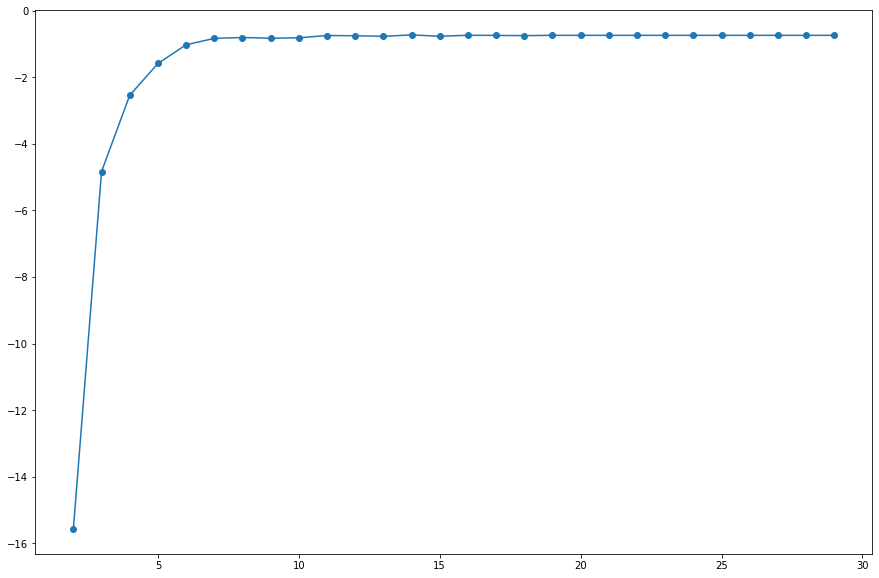

CV     -0.725725
XAX    14.000000
Name: 12, dtype: float64

In [26]:
# Create and fit trees from max_depth 2 to max_depth 30. Use 5-fold CV for each.
CV_score = []
for i in range(2,30):
    tree = RandomForestRegressor(n_estimators=10, max_depth=i, n_jobs=-1, random_state=1,max_features=5,min_samples_leaf=2)
    tree.fit(X_train,y_train)
    ypr = tree.predict(X_test)
    cvsc = cross_val_score(tree, X_train, y_train,scoring='neg_mean_squared_error', cv=5)
    CV_score.append(cvsc.mean())

# Plot the mean CV score vs. maximum depth 

x_axis = np.arange(2,30,1)
plt.scatter(x_axis,CV_score)
plt.plot(x_axis,CV_score)
plt.show()    

# Report the optimal max_depth

maxCV = pd.DataFrame(data={'CV':CV_score, 'XAX' :x_axis})
display(maxCV.iloc[maxCV['CV'].idxmax()])

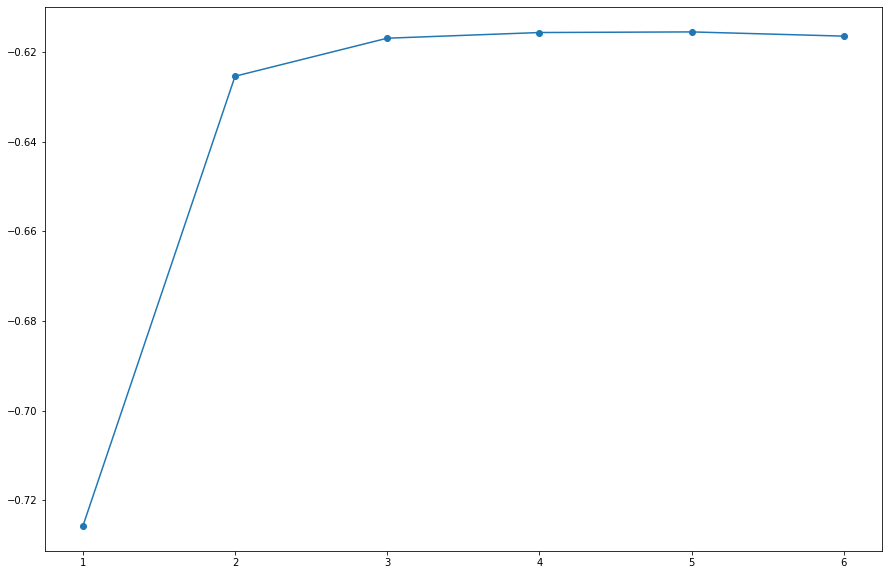

CV    -0.61547
XAX    5.00000
Name: 4, dtype: float64

In [27]:
    
# Create and fit trees from n_est 10 to n_est 100000. Use 5-fold CV for each.
CV_score = []
n_est = [10,100,1000,5000,6000,10000]
for est in n_est:
    tree = RandomForestRegressor(n_estimators=est, max_depth=14, n_jobs=-1, random_state=1,max_features=5,min_samples_leaf=2)
    tree.fit(X_train,y_train)
    ypr = tree.predict(X_test)
    cvsc = cross_val_score(tree, X_train, y_train,scoring='neg_mean_squared_error', cv=5)
    CV_score.append(cvsc.mean())
    
# Plot the mean CV score vs. n_est

x_axis = np.arange(1,7,1)
plt.scatter(x_axis,CV_score)
plt.plot(x_axis,CV_score)
plt.show()


# Report the optimal estimator

maxCV = pd.DataFrame(data={'CV':CV_score, 'XAX' :x_axis})
display(maxCV.iloc[maxCV['CV'].idxmax()])

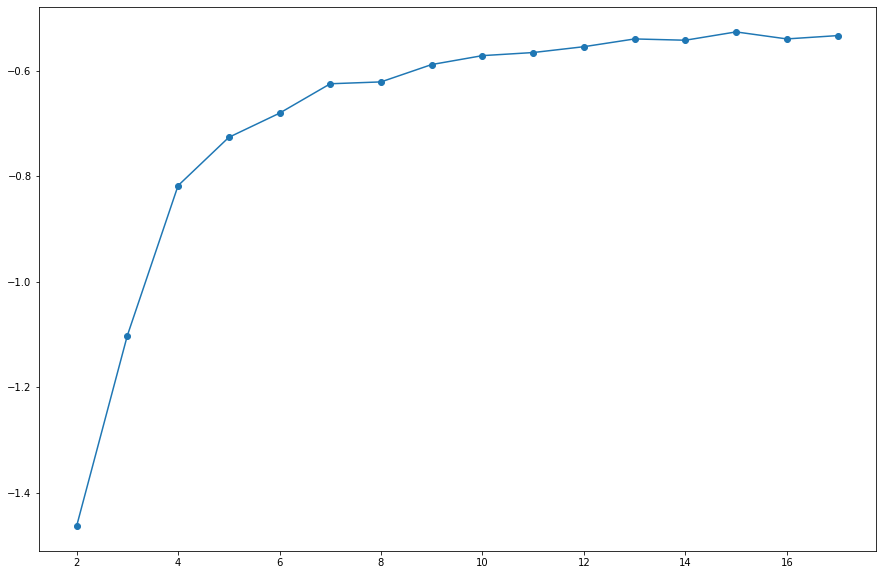

CV     -0.525691
XAX    15.000000
Name: 13, dtype: float64

In [28]:
# Create and fit trees from max_features 2 to max_features 18. Use 5-fold CV for each.
CV_score = []
for i in range(2,18):
    tree = RandomForestRegressor(n_estimators=10, max_depth=14, n_jobs=-1, random_state=1,max_features=i,min_samples_leaf=2)
    tree.fit(X_train,y_train)
    ypr = tree.predict(X_test)
    cvsc = cross_val_score(tree, X_train, y_train,scoring='neg_mean_squared_error', cv=5)
    CV_score.append(cvsc.mean())

# Plot the mean CV score vs. maximum depth 

x_axis = np.arange(2,18,1)
plt.scatter(x_axis,CV_score)
plt.plot(x_axis,CV_score)
plt.show()    

# Report the optimal max_depth

maxCV = pd.DataFrame(data={'CV':CV_score, 'XAX' :x_axis})
display(maxCV.iloc[maxCV['CV'].idxmax()])

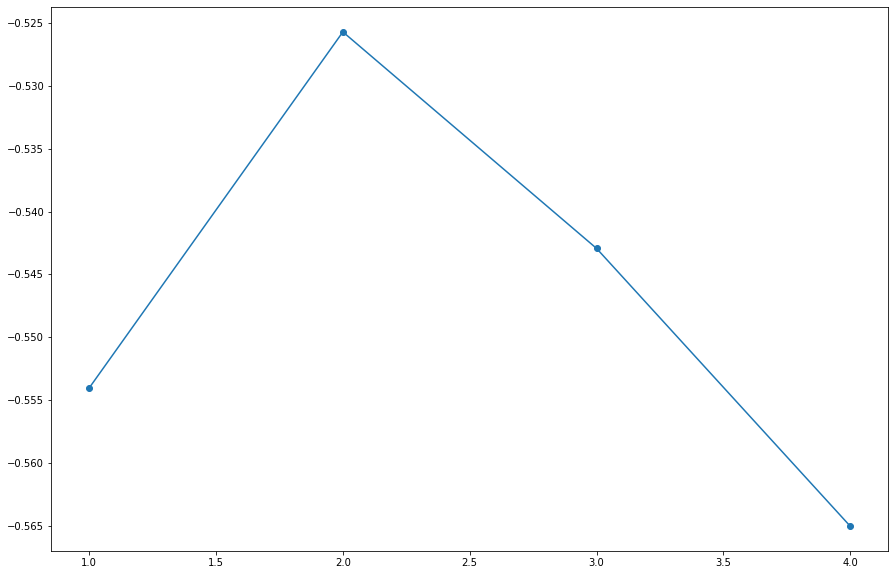

CV    -0.525691
XAX    2.000000
Name: 1, dtype: float64

In [29]:
# Create and fit trees from max_features 2 to max_features 18. Use 5-fold CV for each.
CV_score = []
for i in range(1,5):
    tree = RandomForestRegressor(n_estimators=10, max_depth=14, n_jobs=-1, random_state=1,max_features=15,min_samples_leaf=i)
    tree.fit(X_train,y_train)
    ypr = tree.predict(X_test)
    cvsc = cross_val_score(tree, X_train, y_train,scoring='neg_mean_squared_error', cv=5)
    CV_score.append(cvsc.mean())

# Plot the mean CV score vs. maximum depth 

x_axis = np.arange(1,5,1)
plt.scatter(x_axis,CV_score)
plt.plot(x_axis,CV_score)
plt.show()    

# Report the optimal max_depth

maxCV = pd.DataFrame(data={'CV':CV_score, 'XAX' :x_axis})
display(maxCV.iloc[maxCV['CV'].idxmax()])

In [30]:
rf = RandomForestRegressor(n_estimators=6000, max_depth=14, n_jobs=-1, random_state=1,max_features=5,min_samples_leaf=2)
rf.fit(X_train, y_train)
ypr_rf = rf.predict(X_test)

sum((ypr-y_test)**2)/len(ypr)

# print(ypr)

0.5059596031036637

/Users/seangao/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/seangao/.local/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be

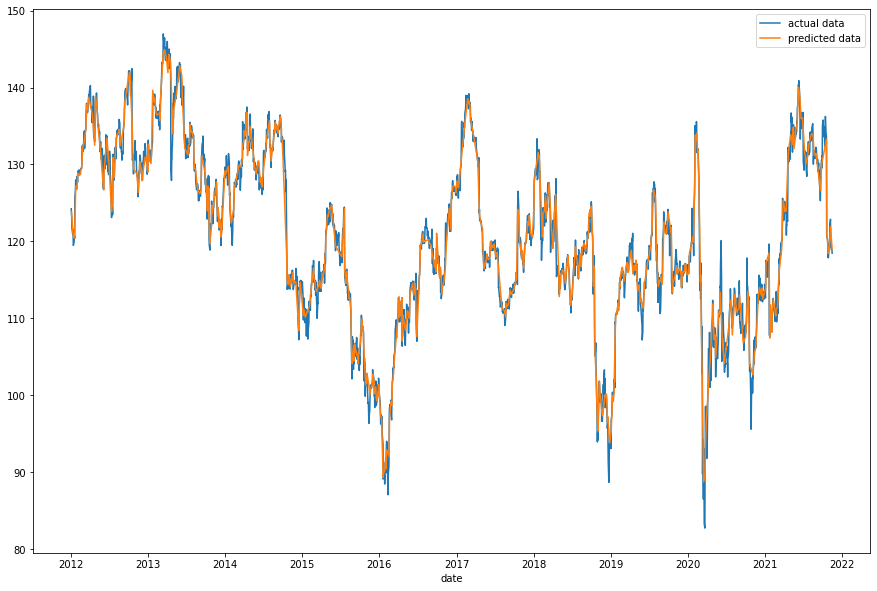

In [31]:
#Convert data column date back into date form
for i in range(len(XX_test)):
  your_timestamp = XX_test.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  XX_test.iloc[i,0] = date.date()
XX_test.date = pd.to_datetime(XX_test['date'])
#plots the Random Forrest model
#plot the predictions
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.plot(data['date'],y, label ="actual data")
ax = sns.lineplot(XX_test.date,ypr_rf, label ="predicted data")
plt.show()


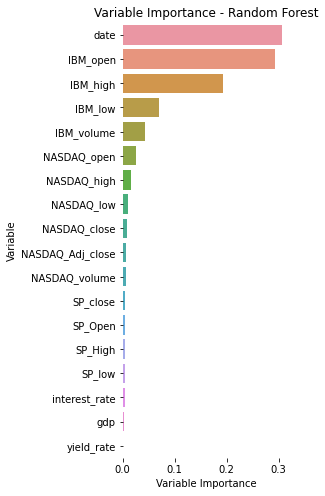

In [32]:
#Plot variable importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3,8))
sns.barplot(y=X.columns,x=importances[indices],label="Total")
plt.title("Variable Importance - Random Forest")
ax.set(ylabel="Variable",xlabel="Variable Importance")
sns.despine(left=True, bottom=True)
plt.show()

Import XGboost pkg to fit a xgboost 

In [33]:
from xgboost import XGBRegressor,XGBRFRegressor
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [34]:

#split the data into train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
XX_test = X_test

In [35]:
# Here we want small trees (unlike with random forests)
# Boosting works better with less data as compared to RF
gb = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=1000, booster='gbtree', gamma=0.001, random_state=0)

In [36]:
## Hyper Parameter Optimization
params={
    "n_estimators"     : range(1000,5000,1000),
    "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [37]:
random_search=RandomizedSearchCV(
    gb,param_distributions=params,n_iter=5,scoring='neg_mean_squared_error',n_jobs=-1,cv=5,verbose=3)

In [38]:
#timer funciton 

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [39]:
#fit the training data into the search models 
from datetime import datetime

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train,y_train)
timer(start_time)


Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time taken: 0 hours 3 minutes and 35.34 seconds.


In [40]:
#show the best estimators
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=4000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
#show best parameters to use 
random_search.best_params_

{'n_estimators': 4000,
 'min_child_weight': 3,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'colsample_bytree': 0.7}

In [42]:
#fitting the fine tuned model (with RandomizedSearchCV)
# gb = XGBRegressor(
#     base_score=0.5, 
#     booster='gbtree', 
#     colsample_bylevel=1,         
#     colsample_bynode=1, 
#     colsample_bytree=0.5, 
#     gamma=0.3, 
#     gpu_id=-1,
#     importance_type='gain', 
#     interaction_constraints='',
#     learning_rate=0.05, 
#     max_delta_step=0, 
#     max_depth=8,
#     min_child_weight=5, 
#     missing=None, 
#     monotone_constraints='()',
#     n_estimators=4000, 
#     n_jobs=8, 
#     num_parallel_tree=1, 
#     random_state=0,
#     reg_alpha=0, 
#     reg_lambda=1, 
#     scale_pos_weight=1, 
#     subsample=1,
#     tree_method='exact', 
#     validate_parameters=1, 
#     verbosity=None)

gb= XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=12,
             min_child_weight=3, missing=None, monotone_constraints='()',
             n_estimators=3000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [43]:
#cv score mean(neg mse)

score=cross_val_score(gb,X_train,y_train,cv=10,scoring='neg_mean_squared_error')
np.mean(score)

-0.5371144180811526

In [44]:
# Train and test
gb.fit(X_train, y_train)
ypr_xg = gb.predict(X_test)



/Users/seangao/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/seangao/.local/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be

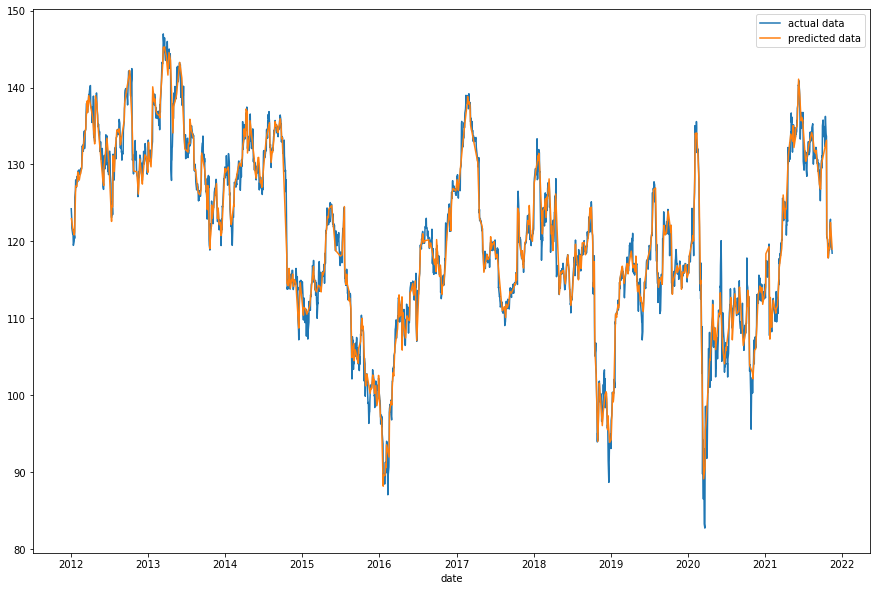

In [45]:
#Convert data column date back into date form
import datetime

for i in range(len(XX_test)):
  your_timestamp = XX_test.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  XX_test.iloc[i,0] = date.date()
XX_test.date = pd.to_datetime(XX_test['date'])
#plots the Random Forrest model
#plot the predictions
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.plot(data['date'],y, label ="actual data")
ax = sns.lineplot(XX_test.date,ypr_xg, label ="predicted data")
plt.show()

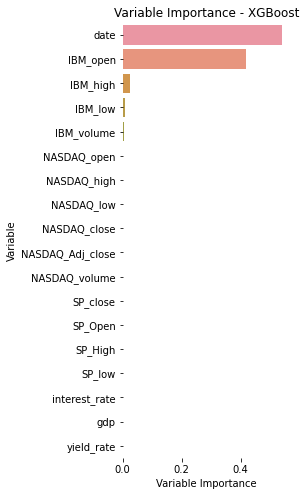

In [46]:


# Plot variable importance
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3,8))
sns.barplot(y=X.columns,x=importances[indices],label="Total")
plt.title("Variable Importance - XGBoost")
ax.set(ylabel="Variable",xlabel="Variable Importance")
sns.despine(left=True, bottom=True)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


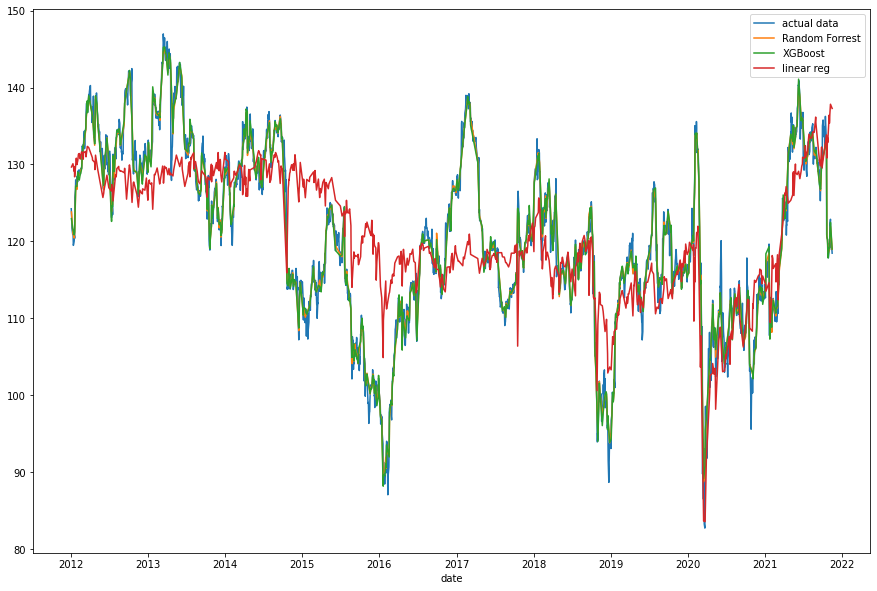

50289.92781246181
398.65516563645366
396.4374169785035


In [47]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.plot(data['date'],y, label ="actual data")

ax = sns.lineplot(XX_test.date,ypr_rf, label ="Random Forrest")
ax = sns.lineplot(XX_test.date,ypr_xg, label ="XGBoost")
ax = sns.lineplot(X_test['date'],y_pred, label ="linear reg")
plt.show()

print(np.mean(sum((y_pred-y_test)**2)))
print(np.mean(sum((ypr_rf-y_test)**2)))
print(np.mean(sum((ypr_xg-y_test)**2)))

In [ ]:
# # Let's do a grid search to tune the model hyperparameters
# # For XGBoost it's important to tune the number of trees (n_estimators) as it easily overfits
param_grid = dict({'n_estimators': range(1,1000,100),'max_depth': range(3,10),'learning_rate' : np.linspace(0.01,1,10)})

grid = GridSearchCV(gb, param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1, refit = True)

grid.fit(X_train,y_train)

In [ ]:
# # Show the best params
#display(grid.cv_results_)
display(grid.best_params_)

In [ ]:
# fitting the parameters after tuning(Grid Search):
xgb_best2 = XGBRegressor(learning_rate= 0.05, max_depth= 7, n_estimators= 801)

In [ ]:
score2 = cross_val_score(xgb_best2, X_train,y_train, cv=10,scoring='neg_mean_squared_error')

In [ ]:
xbg_fit2 = xgb_best2.fit(X_train,y_train)

In [ ]:
display(X_test)

In [ ]:
print(X_test.dtypes)

In [ ]:
xbg_fit2.predict(X_test)